In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle

ORIGINAL_SIZE = (1280, 720)
UNWARPED_SIZE = ORIGINAL_SIZE
CALIB_FILE_NAME = 'calib_file'
straight_images = ["test_images/straight_lines1.jpg", "test_images/straight_lines2.jpg"]
PERSPECTIVE_FILE_NAME = 'perspective_file2.p'

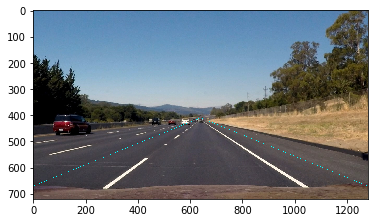

In [13]:
roi_points = np.array([[0, ORIGINAL_SIZE[1]-50],[ORIGINAL_SIZE[0],ORIGINAL_SIZE[1]-50],
       [ORIGINAL_SIZE[0]//2,ORIGINAL_SIZE[1]//2+50]], dtype=np.int32)
roi = np.zeros((ORIGINAL_SIZE[1], ORIGINAL_SIZE[0]), dtype=np.uint8)
cv2.fillPoly(roi, [roi_points], 1)
img = mpimg.imread(straight_images[1])
cv2.polylines(img, [roi_points],True,(0,255,255))
plt.imshow(img)
plt.show()


In [14]:
with open(CALIB_FILE_NAME, 'rb') as f:
    calib_data = pickle.load(f)
    cam_matrix = calib_data["cam_matrix"]
    dist_coeffs = calib_data["dist_coeffs"]

In [39]:
def check_cmap(image):
    cmap = None
    if len(image.shape) < 3:
        cmap = 'gray'
    return cmap
def show_images(images, titles):
    plt.clf()
    if len(images) == 4:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    
    ax1.imshow(images[0], cmap=check_cmap(images[0]))
    ax1.set_title(titles[0], fontsize=30)
    ax2.imshow(images[1], cmap=check_cmap(images[1]))
    ax2.set_title(titles[1], fontsize=30)
    ax3.imshow(images[2], cmap=check_cmap(images[2]))
    ax3.set_title(titles[2], fontsize=30)
    if len(images) == 4:
        ax4.imshow(images[3], cmap=check_cmap(images[2]))
        ax4.set_title(titles[3], fontsize=30)
    plt.show()

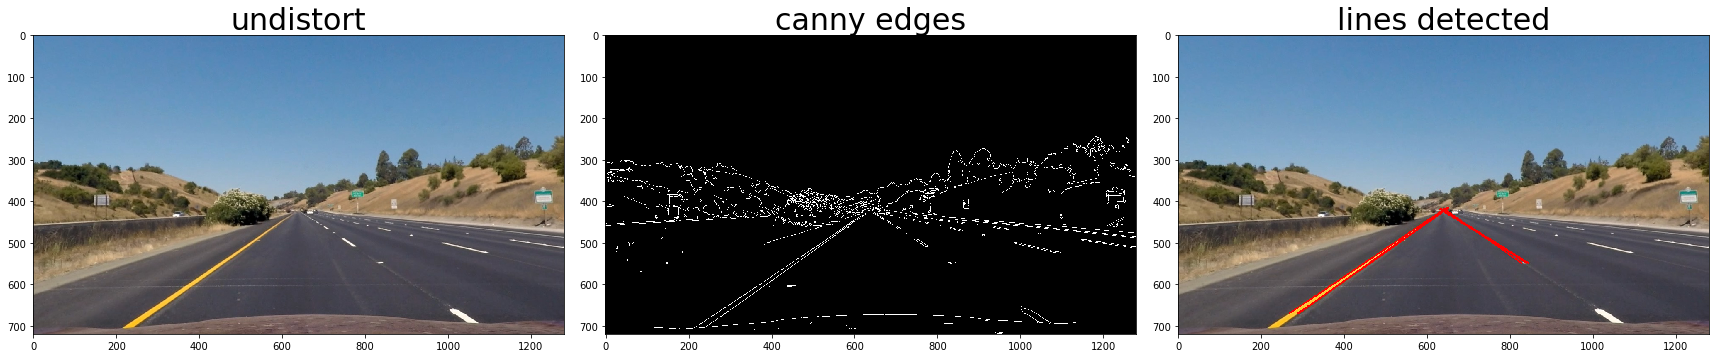

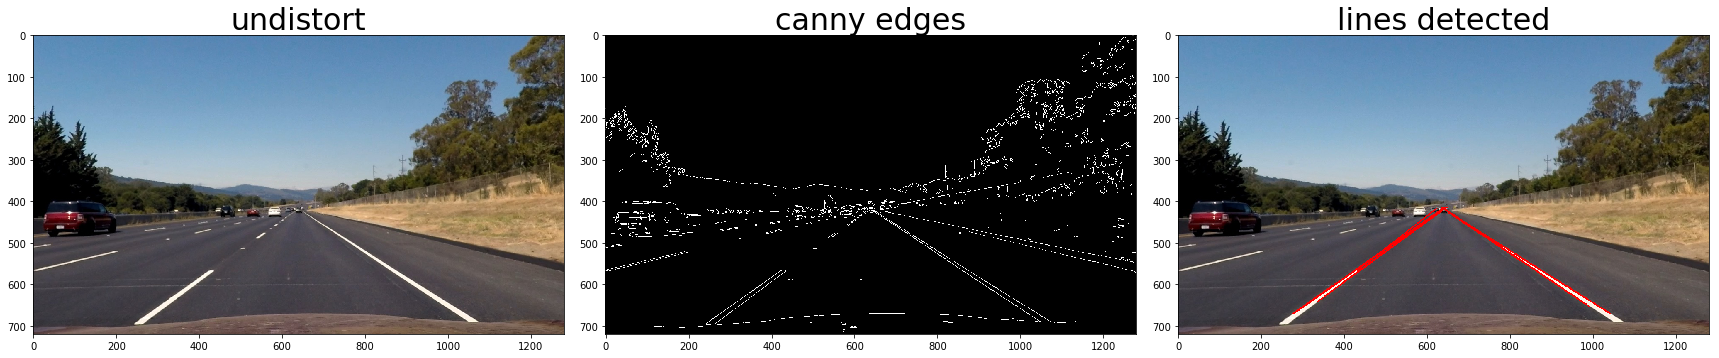

In [27]:
Lhs = np.zeros((2,2), dtype= np.float32)
Rhs = np.zeros((2,1), dtype= np.float32)

for img_path in straight_images:
    images = []
    img = mpimg.imread(img_path)
    img = cv2.undistort(img, cam_matrix, dist_coeffs)
    images.append(img)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    edges = cv2.Canny(img_hls[:, :, 1], 200, 100)
    
    lines = cv2.HoughLinesP(edges*roi, 0.5, np.pi/180, 20, None, 180, 120)
    img_lines = np.copy(img)
    if len(lines) > 0:
        for line in lines:
            for x1, y1, x2, y2 in line:
                normal = np.array([[-(y2-y1)], [x2-x1]], dtype=np.float32)
                normal /= np.linalg.norm(normal)
                point = np.array([[x1],[y1]], dtype=np.float32)
                outer = np.matmul(normal, normal.T)
                Lhs += outer
                Rhs += np.matmul(outer, point)
                cv2.line(img_lines, (x1,y1), (x2, y2),(255, 0, 0), thickness=2)
            
    images.append(edges)
    images.append(img_lines)

    show_images(images, ['undistort', 'canny edges', 'lines detected'])
    
    
# calculate the vanishing point
vanishing_point = np.matmul(np.linalg.inv(Lhs),Rhs)
# plt.imshow(img)
# plt.scatter(vanishing_point[0],vanishing_point[1])
# plt.show()

In [28]:
VIDEO_HEIGHT = 720
VIDEO_WIDTH = 1280
TRAPEZE_TOP_MARGIN = 572
TRAPEZE_BOTTOM_MARGIN = 0
TRAPEZE_TOP = 450
PAD=0
ORIGINAL_SIZE = (1280, 720)
UNWARPED_SIZE = ORIGINAL_SIZE

# Source points - Trapezoid
top_left = [TRAPEZE_TOP_MARGIN, TRAPEZE_TOP]
top_right = [VIDEO_WIDTH - TRAPEZE_TOP_MARGIN, TRAPEZE_TOP]
low_left = [TRAPEZE_BOTTOM_MARGIN, VIDEO_HEIGHT]
low_right = [VIDEO_WIDTH - TRAPEZE_BOTTOM_MARGIN, VIDEO_HEIGHT]
# src = np.float32([top_left, top_right, low_right, low_left])

width = ORIGINAL_SIZE[0]-PAD
height = ORIGINAL_SIZE[1]-PAD
dst = np.float32([[PAD,PAD],[width,PAD],[width,height],[PAD,height]])

src = np.array([top_left,top_right,low_right, low_left], np.float32)
# src = pts.reshape((-1,1,2))

m = cv2.getPerspectiveTransform(src, dst)
m_inverse = cv2.getPerspectiveTransform(dst, src)

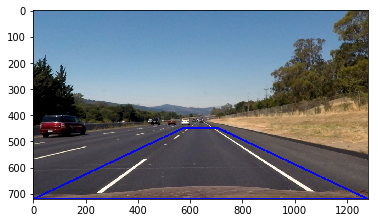

In [29]:
cv2.polylines(img, [src.astype(np.int32)],True, (0,0,255), thickness=5)
plt.imshow(img)
plt.show()

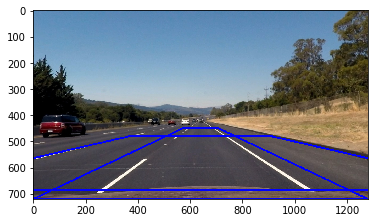

In [30]:
# get additional trapezoides using the vanishing point
top = vanishing_point[1] + 60
bottom = ORIGINAL_SIZE[1]-35
width = 530
def on_line(p1, p2, ycoord):
    return [p1[0]+ (p2[0]-p1[0])/float(p2[1]-p1[1])*(ycoord-p1[1]), ycoord]


#define source and destination targets
p1 = [vanishing_point[0] - width/2, top]
p2 = [vanishing_point[0] + width/2, top]
p3 = on_line(p2, vanishing_point, bottom)
p4 = on_line(p1, vanishing_point, bottom)
src_points = np.array([p1,p2,p3,p4], dtype=np.float32)

dst_points = np.array([[0, 0], [UNWARPED_SIZE[0], 0],
                       [UNWARPED_SIZE[0], UNWARPED_SIZE[1]],
                       [0, UNWARPED_SIZE[1]]], dtype=np.float32)

cv2.polylines(img, [src_points.astype(np.int32)],True, (0,0,255), thickness=5)
plt.imshow(img)
plt.show()

847.7 pixels bw lane lines ==> 231.76 pixels per meter on dim x


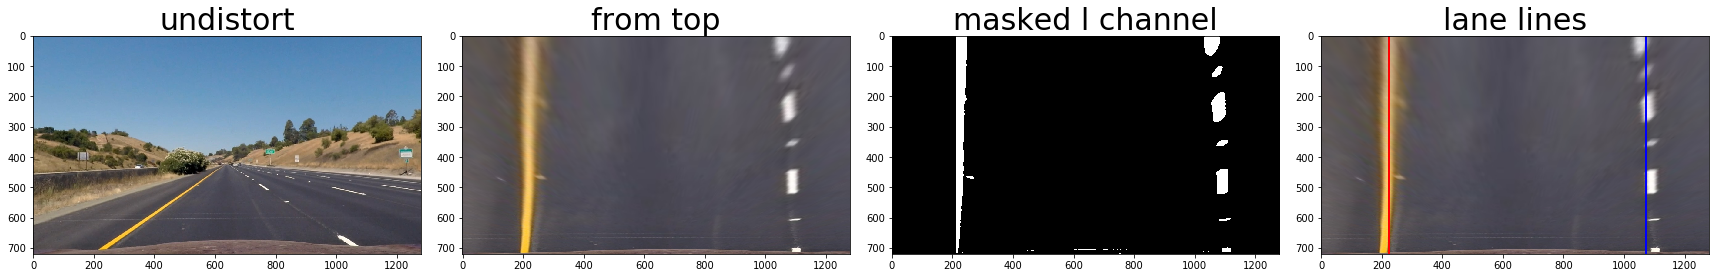

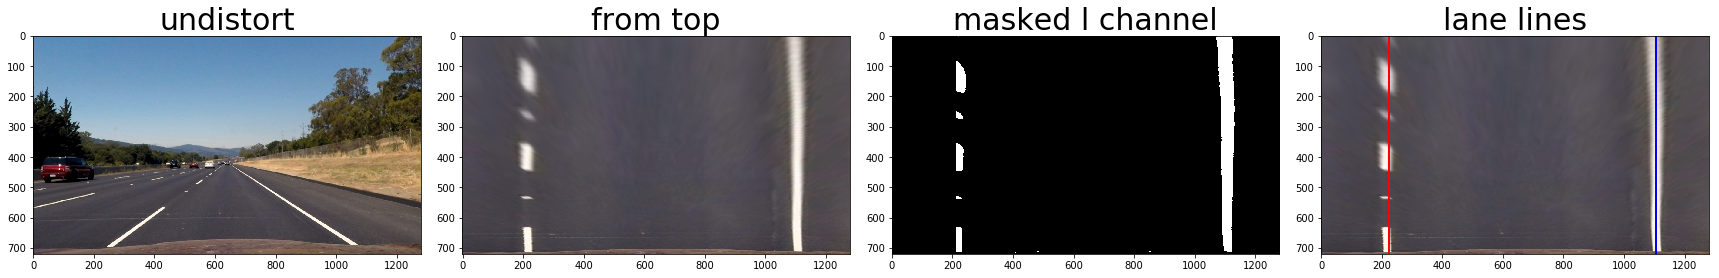

pix_per_meter_x: 231.76 pix_per_meter_y: 17.12


In [45]:
meter_per_foot = 1/3.28084
#find the projection matrix
M = cv2.getPerspectiveTransform(src, dst)
min_wid = 1000

for img_path in straight_images:
    images = []
    img = mpimg.imread(img_path)
    undist = cv2.undistort(img, cam_matrix, dist_coeffs)

    from_top = cv2.warpPerspective(undist, M, UNWARPED_SIZE)
    
    img_hls = cv2.cvtColor(from_top, cv2.COLOR_RGB2HLS)
    mask = img_hls[:,:,1]>130
    mask[:, :210]=0
    mask[:, -50:]=0

    mom = cv2.moments(mask[:,:UNWARPED_SIZE[0]//2].astype(np.uint8))
#     print(mom, '\n')
    x1 = mom["m10"]/mom["m00"]
    mom = cv2.moments(mask[:,UNWARPED_SIZE[0]//2:].astype(np.uint8))
#     print(mom, '\n')
    x2 = UNWARPED_SIZE[0]//2 + mom["m10"]/mom["m00"]
    img = np.copy(from_top)
    cv2.line(img, (int(x1), 0), (int(x1), UNWARPED_SIZE[1]), (255, 0, 0), 5)
    cv2.line(img, (int(x2), 0), (int(x2), UNWARPED_SIZE[1]), (0, 0, 255), 5)
    if (x2-x1<min_wid):
        min_wid = x2-x1
        print (round(min_wid,1), 'pixels bw lane lines ==>', 
               round(min_wid/(12*meter_per_foot),2), 'pixels per meter on dim x')
    
    images.append(undist)
    images.append(from_top)
    images.append(mask)
    images.append(img)
    show_images(images, ['undistort', 'from top', 'masked l channel', 'lane lines'])
    
pix_per_meter_x = min_wid/(12* meter_per_foot)
Lh = np.linalg.inv(np.matmul(M, cam_matrix))
pix_per_meter_y = pix_per_meter_x * np.linalg.norm(Lh[:,0]) / np.linalg.norm(Lh[:,1])
print('pix_per_meter_x:', round(pix_per_meter_x,2), 'pix_per_meter_y:',round(pix_per_meter_y,2))

perspective_data = {'perspective_transform': M,
                    'pixels_per_meter': (pix_per_meter_x, pix_per_meter_y),
                    'orig_points': src,
                    'dst_points': dst}
with open(PERSPECTIVE_FILE_NAME, 'wb') as f:
    pickle.dump(perspective_data, f)